In [1]:
import wget

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
import os
import csv
import json
import pandas as pd
import numpy as np
import operator
import pprint
import collections
from collections import Counter
from collections import defaultdict
from glob import glob
import spacy
import scipy.io
import imageio
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.utils import generic_utils
from keras.preprocessing import image
import tensorflow as tf
from sklearn import preprocessing
from keras.models import Model
from keras.layers import multiply
from keras import regularizers
from keras.layers import *
from random import shuffle
from keras import optimizers
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.layers.core import Dense, Dropout, Activation


print(f"Tensor Flow Version: {tf.__version__}")
cpu = len(tf.config.list_physical_devices('CPU'))>0
print("CPU is", "available" if cpu else "NOT AVAILABLE")

2022-10-30 14:42:21.433589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensor Flow Version: 2.10.0
CPU is available


# Downloading VQA Dataset :

In [4]:
def download_vqa():
    os.system('wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip -P zip/')
    os.system('wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip -P zip/')
    os.system('wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Test_mscoco.zip -P zip/')
    
     # Download the VQA Annotations
    os.system('wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip -P zip/')
    os.system('wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip -P zip/')
    
      # Unzip the annotations
    os.system('unzip zip/v2_Questions_Train_mscoco.zip -d annotations/')
    os.system('unzip zip/v2_Questions_Val_mscoco.zip -d annotations/')
    os.system('unzip zip/v2_Questions_Test_mscoco.zip -d annotations/')
    os.system('unzip zip/v2_Annotations_Train_mscoco.zip -d annotations/')
    os.system('unzip zip/v2_Annotations_Val_mscoco.zip -d annotations/')

In [5]:
#download_vqa()

# Downloading COCO Images :

In [6]:
def download_images():
    os.system('wget http://images.cocodataset.org/zips/train2014.zip -P coco_images/')
    os.system('wget http://images.cocodataset.org/zips/val2014.zip -P coco_images/')
    os.system('wget http://images.cocodataset.org/zips/test2015.zip -P coco_images/')

    # Unzip the coco_images
    os.system('unzip coco_images/train2014.zip -d train/')
    os.system('unzip coco_images/val2014.zip -d validation/')
    os.system('unzip coco_images/test2015.zip -d test/')

In [7]:
#download_images()

# Loading Dataset :

In [8]:
print('loading datas...')

train_question = json.load(open('/Users/rajnishjha/Downloads/annotations/v2_OpenEnded_mscoco_train2014_questions.json'))
train_answer = json.load(open('/Users/rajnishjha/Downloads/annotations/v2_mscoco_train2014_annotations.json'))

val_question = json.load(open('/Users/rajnishjha/Downloads/annotations/v2_OpenEnded_mscoco_val2014_questions.json'))
val_answer = json.load(open('/Users/rajnishjha/Downloads/annotations/v2_mscoco_val2014_annotations.json'))

test_question1 = json.load(open('/Users/rajnishjha/Downloads/annotations/v2_OpenEnded_mscoco_test2015_questions.json'))
test_question2 = json.load(open('/Users/rajnishjha/Downloads/annotations/v2_OpenEnded_mscoco_test-dev2015_questions.json'))

print('#'*50)
print('data loaded')

loading datas...
##################################################
data loaded


In [9]:
print("Total no. of training question are",len(train_question['questions']))
print("Total no. of training answers are",len(train_answer['annotations']))

print("Total no. of validation question are",len(val_question['questions']))
print("Total no. of validation answers are",len(val_answer['annotations']))

print("Total no. of test question1 are",len(test_question1['questions']))
print("Total no. of test question2 are",len(test_question2['questions']))

Total no. of training question are 443757
Total no. of training answers are 443757
Total no. of validation question are 214354
Total no. of validation answers are 214354
Total no. of test question1 are 447793
Total no. of test question2 are 107394


In [10]:
def fillup(my_set, my_list, K):

    length = len(my_set) + K
    i = 0

    while len(my_set) != length:
        my_set[my_list[i]] = 0
        i += 1

    return my_set

In [11]:
def bow(train_question, val_question, K=2000):

    questions = train_question['questions']
    ques_val = val_question['questions']
    d = dict()

    q_array = [questions, ques_val]

    for data in q_array:
        for q in data:
            question = q['question'][:-1].lower().split()

            for w in question:
                d[w] = 1 if w not in d else d[w] + 1

    KmostFreqWords = np.array(sorted(d.items(), key=operator.itemgetter(1), reverse=True))[:K, 0]

    return list(KmostFreqWords)

In [12]:
bow_q = bow(train_question, val_question, K=2000)

In [13]:
def bow_q123(train_question, val_question, K=20):

    questions = train_question['questions']
    ques_val = val_question['questions']

    firstWords = dict()
    secondWords = dict()
    thirdWords = dict()

    q_array = [questions, ques_val]

    for data in q_array:
        for q in data:
            question = q['question'][:-1].lower().split()

            if len(question) >= 1:
                firstWords[question[0]] = 1 if question[0] not in firstWords else firstWords[question[0]] + 1

            if len(question) >= 2:
                secondWords[question[1]] = 1 if question[1] not in secondWords else secondWords[question[1]] + 1

            if len(question) >= 3:
                thirdWords[question[2]] = 1 if question[2] not in thirdWords else thirdWords[question[2]] + 1

    top10_1w = np.array(sorted(firstWords.items(), key=operator.itemgetter(1), reverse=True))[:, 0]
    top10_2w = np.array(sorted(secondWords.items(), key=operator.itemgetter(1), reverse=True))[:, 0]
    top10_3w = np.array(sorted(thirdWords.items(), key=operator.itemgetter(1), reverse=True))[:, 0]

    unique_words = collections.OrderedDict()
    unique_words = fillup(unique_words, top10_1w, K)
    unique_words = fillup(unique_words, top10_2w, K)
    unique_words = fillup(unique_words, top10_3w, K)
    return list(unique_words)

In [14]:
bow_123 = bow_q123(train_question, val_question, K=20)

In [15]:
def preprocess_data(train_question, train_answer, val_question, val_answer):

    keys = ['images_id', 'questions_id', 'questions', 'questions_len', 'answers']
    training_dict = dict((k, []) for k in keys)
    validation_dict = dict((k, []) for k in keys)
    answers = []

    data_ans = train_answer['annotations']
    data_ques = train_question['questions']
    data_ans_val = val_answer['annotations']
    data_ques_val = val_question['questions']

    ques = [data_ques, data_ques_val]
    ans = [data_ans, data_ans_val]

    d = collections.defaultdict(dict)

    for qu in ques:
        for i in range(len(qu)):
            q_id = qu[i]['question_id']
            img_id = qu[i]['image_id']
            question = qu[i]['question']
            d[img_id][q_id] = [question,len(question.split()) + 1] 

    for idx, an in enumerate(ans):
        for i in range(len(an)):
            if idx == 0:
                img_id = an[i]['image_id']
                q_id = an[i]['question_id']

                training_dict['questions_id'].append(q_id)
                training_dict['images_id'].append(img_id)
                training_dict['answers'].append(an[i]['multiple_choice_answer'])
                answers.append(an[i]['multiple_choice_answer'])

                training_dict['questions'].append(d[img_id][q_id][0])
                training_dict['questions_len'].append(d[img_id][q_id][1])
            else:
                img_id = an[i]['image_id']
                q_id = an[i]['question_id']
                
                validation_dict['questions_id'].append(q_id)
                validation_dict['images_id'].append(img_id)
                validation_dict['answers'].append(an[i]['multiple_choice_answer'])
                answers.append(an[i]['multiple_choice_answer'])

                validation_dict['questions'].append(d[img_id][q_id][0])
                validation_dict['questions_len'].append(d[img_id][q_id][1])

    return training_dict, validation_dict, answers

In [16]:
def topKFrequentAnswer(data_q, data_a, data_qval, data_aval, K=2000):

    training_dict, validation_dict, answers = preprocess_data(data_q, data_a, data_qval, data_aval)
    
    d = dict()

    for answer in answers:
        d[answer] = 1 if answer not in d else d[answer] + 1

    topKAnswers = np.array(sorted(d.items(), key=lambda x: (x[1], x[0]), reverse=True)[:K])[:, 0]

    keys = ['images_id', 'questions_id', 'questions', 'questions_len', 'answers']
    K_training_dict = dict((k, []) for k in keys)
    K_validation_dict = dict((k, []) for k in keys)

    dicts = [training_dict, validation_dict]
    K_dicts = [K_training_dict, K_validation_dict]

    for di, K_di in zip(dicts, K_dicts):
        for idx, ans in enumerate(di['answers']):
            if ans in topKAnswers:
                K_di['images_id'].append(di['images_id'][idx])
                K_di['questions_id'].append(di['questions_id'][idx])
                K_di['questions'].append(di['questions'][idx])
                K_di['questions_len'].append(di['questions_len'][idx])
                K_di['answers'].append(di['answers'][idx])

    return K_training_dict, K_validation_dict, topKAnswers

In [17]:
K_train_dict, K_val_dict, topKAnswers = topKFrequentAnswer(train_question,train_answer, val_question, val_answer)

In [18]:
topKAnswers

array(['yes', 'no', '1', ..., 'lace', 'joshua', 'jelly'], dtype='<U21')

In [19]:
def getVoc(training_questions, validation_questions):

    voc = collections.OrderedDict()
    for q in training_questions:
        words = q[:-1].lower().split() # -1 to trim '?'
        for w in words:
            voc[w] = 0

    for q in validation_questions:
        words = q[:-1].lower().split() # -1 to trim '?'
        for w in words:
            voc[w] = 0

    return {v: i for i, (v, k) in enumerate(voc.items())}

In [20]:
K_images_id, K_questions_id, K_questions, K_questions_len, K_answers = K_train_dict['images_id'], K_train_dict['questions_id'], K_train_dict['questions'], K_train_dict['questions_len'], K_train_dict['answers']
K_images_val_id, K_questions_val_id, K_questions_val, K_questions_val_len, K_answers_val = K_val_dict['images_id'], K_val_dict['questions_id'], K_val_dict['questions'], K_val_dict['questions_len'], K_val_dict['answers']

vocabulary = getVoc(K_questions, K_questions_val)


In [21]:
import pandas as pd
import numpy as np
import glob
import os

train_img = glob.glob("/Users/rajnishjha/Downloads/train/train2014/*.jpg")
train_img.sort()
val_img = glob.glob("/Users/rajnishjha/Downloads/validation/val2014/*.jpg")
val_img.sort()

In [22]:
print('Num of training images:', len(train_img))
print('Num of validation images:', len(val_img))

Num of training images: 82783
Num of validation images: 123287


# Combine train + Validation Images

import glob
import shutil
import os

src_dir = "/Users/rajnishjha/Downloads/train/train2014/"
dst_dir = "/Users/rajnishjha/Downloads/validation/val2014/"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [23]:
tr = glob.glob("/Users/rajnishjha/Downloads/train/train2014/*.jpg")
tr.sort()
val = glob.glob("/Users/rajnishjha/Downloads/validation/val2014/*.jpg")
val.sort()

In [24]:
print('Num of training images:', len(tr))
print('Num of validation images:', len(val))

Num of training images: 82783
Num of validation images: 123287


In [25]:
d = dict.fromkeys(list(map(lambda x: int(x[-16:-4]), glob.glob('/Users/rajnishjha/Downloads/validation/val2014/*.jpg'))), '')

In [26]:
l = list(map(lambda x: int(x[-16:-4]), glob.glob('/Users/rajnishjha/Downloads/validation/val2014/*.jpg')))
for i, image_id in enumerate(l):
    d[image_id] = i

json.dump(d, open("train_val_image_to_index.json",'w'))

In [27]:
test_d = dict.fromkeys(list(map(lambda x: int(x[-16:-4]), glob.glob('/Users/rajnishjha/Downloads/test/test2015/*.jpg'))), '')
test_l = list(map(lambda x: int(x[-16:-4]), glob.glob('/Users/rajnishjha/Downloads/test/test2015/*.jpg')))
for i, image_id in enumerate(test_l):
    test_d[image_id] = i

json.dump(test_d, open("test_id_image_to_index.json",'w'))

In [28]:
_, K_val_dict, topKAnswers = topKFrequentAnswer(train_question, train_answer, val_question, val_answer)

K_images_val_id, K_questions_val_id, K_questions_val, K_questions_val_len, K_answers_val = K_val_dict['images_id'], K_val_dict['questions_id'], K_val_dict['questions'], K_val_dict['questions_len'], K_val_dict['answers']


In [29]:
img_ptr = 0
q_ptr = 0
c = 0

with open('answers.csv', 'w', newline='') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
    for obj in val_answer['annotations']:
        if (obj['image_id'] == K_images_val_id[img_ptr] and 
            obj['question_id'] == K_questions_val_id[q_ptr]):
            
            q_ptr += 1
            img_ptr += 1
            
            l = []
            for a in obj['answers']:
                l.append(a['answer'])
                wr.writerow(l)


# VGG 19 :

In [30]:
import ssl 

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

vgg19_model = VGG19(weights='imagenet', include_top=True)
vgg19_model.summary()

2022-10-30 14:43:17.544121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 14:43:17.545785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-30 14:43:17.545911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 14:43:17.546420: I tensorflow/core/common_runtime/pluggable_device/plug

Metal device set to: AMD Radeon Pro 5500M
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPo

In [31]:
vgg19_model_extractfeatures = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer('fc2').output)

# Feature Extract :

In [32]:
def path_to_tensor(img_path):
    
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img)
    return np.expand_dims(x, axis=0)

def extract_features(img_path, model):
    
    x = preprocess_input(path_to_tensor(img_path))
    fc2_features = model.predict(x)
    return fc2_features

In [33]:
img_path = '/Users/rajnishjha/Downloads/train/train2014/COCO_train2014_000000000034.jpg'
feats = extract_features(img_path, vgg19_model_extractfeatures)
feats.shape

2022-10-30 14:43:20.931591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 888ms/step


(1, 4096)

In [34]:
import scipy.io
import os

def img_features_keras(path, output_name, model, dim):
    img_paths = np.asarray(glob.glob(path))
    features = np.zeros((len(img_paths), dim), dtype=np.float32)
    for i, img_path in enumerate(img_paths):
        features[i] = extract_features(img_path, model)
        if i % 2000 == 0:
            print('.', end=' ', flush=True)
            scipy.io.savemat(os.path.join(output_name + '.mat'), mdict =  {'features': np.transpose(features)})
            return None

In [35]:
img_features_keras('/Users/rajnishjha/Downloads/validation/val2014/*.jpg', 'VGG19_train_val_image_feat', vgg19_model_extractfeatures, 4096)


1/1 [==============================] - 0s 27ms/step
. 

In [36]:
img_features_keras('/Users/rajnishjha/Downloads/test/test2015/*.jpg', 'VGG19_test_image_feat', vgg19_model_extractfeatures, 4096)


1/1 [==============================] - 0s 33ms/step
. 

In [37]:
features = scipy.io.loadmat('/Users/rajnishjha/Downloads/VGG19_train_val_image_feat.mat')['features']
word_embeddings = spacy.load('en_core_web_trf')
train_img_id_to_idx = json.load(open('/Users/rajnishjha/Downloads/train_val_image_to_index.json')) 

In [38]:
len(features)

4096

In [39]:
len(train_img_id_to_idx)

123287

In [40]:
def q_embedding(question, bow_q, bow_123):

    q_array = question[:-1].lower().split()
    emb_q = np.array([q_array.count(item) for item in bow_q])
    emb_123 = np.array([q_array.count(item) for item in bow_123])
    return np.r_[emb_q, emb_123]

In [41]:
q_embedding('What is this photo taken looking through?', bow_q, bow_123)

array([0, 1, 1, ..., 0, 0, 0])

In [42]:
def bow_embeddings(questions, bow_q, bow_123):   

    bow = np.zeros((len(questions), 2060)) 

    for i, question in enumerate(questions):
        bow[i] = q_embedding(question, bow_q, bow_123)

    return bow

In [43]:
def answers_vectors(answers_list, encoder):

    nb_classes = encoder.classes_.shape[0]
    y = encoder.transform(answers_list)

    return np_utils.to_categorical(y, nb_classes)

In [44]:
def batch(iterable, n=1):

    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [45]:
def question_features(question):

    tokens = word_embeddings(question)
    features = np.zeros((len(tokens), 300))
  
    for i, token in enumerate(tokens):
        features[i, :] = token.vector

    return features

In [46]:
def questions_to_tensors(questions, max_len):
    
    res = np.zeros((len(questions), max_len, 300)) 

    for i, question in enumerate(questions):
        q_word2vec = question_features(question)
        nb_words, _ = q_word2vec.shape
        res[i,max_len-nb_words:] = q_word2vec

    return res

In [47]:
def answer_to_tensors(answers, encoder):

    y = encoder.transform(answers)
    nb_classes = encoder.classes_.shape[0]
    Y = np_utils.to_categorical(y, nb_classes)
    return 

In [48]:
def images_to_tensors(images):
    img_embed = np.zeros((len(images), 4096))
    for idx, i in enumerate(images):
        img_embed[idx] = features[:, train_img_id_to_idx["%s" % i]]
    return img_embed

In [49]:
def getEmbeddings(voc_list):

    embeddings = np.zeros((len(voc_list), 300))
    for w, i in voc_list.items():
        embeddings[i] = word_embeddings(w).vector
    return embeddings

In [50]:
def question_index(questions, voc, max_len):

    res = np.zeros((len(questions), max_len))

    for i, question in enumerate(questions):
        q = list()
        for w in question[:-1].lower().split():
            q.append(voc[w])
        nb_words  = len(q)
        res[i,max_len-nb_words:] = np.array(q)

    return res

In [51]:
def bowq_i(questions_list, images_id_list, bow_q, bow_123):
    return np.hstack((bow_embeddings(questions_list, bow_q, bow_123),
                    images_to_tensors(images_id_list)))

# BOW MODEL :

In [52]:
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense, Dropout, Activation

In [53]:
img_dim = 4096
bow_dim = 2060
hidden_layers = 2
hidden_units = 1000
dropout = 0.5
activation = 'tanh'
nb_classes = len(topKAnswers)


model = Sequential()
model.add(Dense(hidden_units, input_dim=img_dim + bow_dim))
model.add(Activation(activation))
model.add(Dropout(dropout))

for i in range(hidden_layers):
    model.add(Dense(hidden_units,))
    model.add(Activation(activation))
    model.add(Dropout(dropout))

model.add(Dense(nb_classes,))
model.add(Activation('softmax'))

adam = Adam(learning_rate=0.001, beta_1=0.8, beta_2=0.999, epsilon=1e-08, decay=1-0.99)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

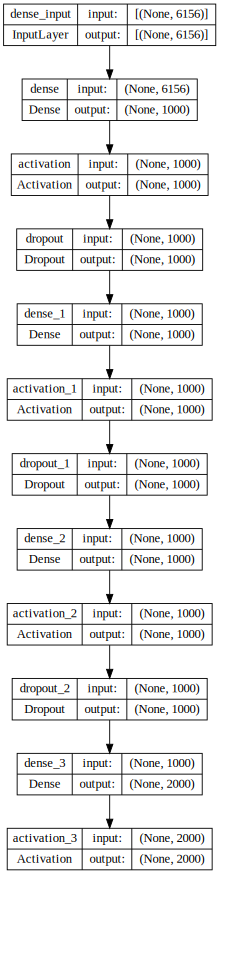

In [54]:
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## TRAINING :

In [55]:
from sklearn import preprocessing

labelencoder = preprocessing.LabelEncoder()
label = labelencoder.fit_transform(topKAnswers)
nb_classes = len(list(labelencoder.classes_))

In [56]:
print(topKAnswers)
print(label)

['yes' 'no' '1' ... 'lace' 'joshua' 'jelly']
[1991 1145    1 ...  969  933  928]


In [57]:
ep = 100
batch_size = 128

samples_train = int(len(K_questions) / batch_size)
samples_val = int(len(K_questions_val) / batch_size)

In [58]:
print(samples_train)
print(samples_val)

3159
1524


# TRAINING BOW :

In [59]:
print('start training...')

print('*'*50)

def generator(isTrain, batch_size):
    i = 0
    l = len(K_questions)
    lv = len(K_questions_val)
    while 1:
        if (isTrain):

            X_batch = bowq_i(K_questions[i:min(i + batch_size, l)], K_images_id[i:min(i + batch_size, l)], bow_q, bow_123)
            Y_batch = answers_vectors(K_answers[i:min(i + batch_size, l)], labelencoder)
        else:

            X_batch = bowq_i(K_questions_val[i:min(i + batch_size, l)], K_images_val_id[i:min(i + batch_size, l)], bow_q, bow_123)
            Y_batch = answers_vectors(K_answers_val[i:min(i + batch_size, l)], labelencoder)

        yield X_batch, Y_batch

        i += batch_size

        if isTrain and i > l:
            i = 0
        if not isTrain and i > lv:
            i = 0

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=False)

history = model.fit(generator(True, batch_size=batch_size), steps_per_epoch = samples_train, epochs=ep,
                    validation_data=generator(False, batch_size=batch_size),
                    callbacks=[checkpointer], validation_steps=samples_val)


start training...
**************************************************
Epoch 1/100


2022-10-30 14:43:37.314035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3158/3159 [============================>.] - ETA: 0s - loss: 2.8203 - accuracy: 0.3042

2022-10-30 14:46:41.824754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to weights/weights.01-2.58.hdf5
3159/3159 [==============================] - 267s 84ms/step - loss: 2.8202 - accuracy: 0.3042 - val_loss: 2.5838 - val_accuracy: 0.3315
Epoch 2/100
3159/3159 [==============================] - ETA: 0s - loss: 2.4279 - accuracy: 0.3562
Epoch 2: saving model to weights/weights.02-2.50.hdf5
3159/3159 [==============================] - 266s 84ms/step - loss: 2.4279 - accuracy: 0.3562 - val_loss: 2.4971 - val_accuracy: 0.3397
Epoch 3/100
3159/3159 [==============================] - ETA: 0s - loss: 2.3348 - accuracy: 0.3699
Epoch 3: saving model to weights/weights.03-2.46.hdf5
3159/3159 [==============================] - 273s 86ms/step - loss: 2.3348 - accuracy: 0.3699 - val_loss: 2.4575 - val_accuracy: 0.3427
Epoch 4/100
3159/3159 [==============================] - ETA: 0s - loss: 2.2827 - accuracy: 0.3779
Epoch 4: saving model to weights/weights.04-2.43.hdf5
3159/3159 [==============================] - 277s 88ms/step - loss: 2.2827 - a

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              6157000   
                                                                 
 activation (Activation)     (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 activation_1 (Activation)   (None, 1000)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1

In [61]:
with open('model_architecture_after_training.json', 'w') as f:
    f.write(model.to_json())

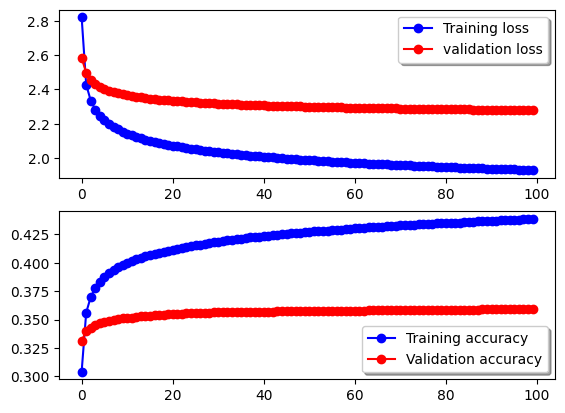

In [62]:
# Plot the loss and accuracy curves for training and validation 

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss",marker='o')
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",marker='o',axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy",marker='o')
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy",marker='o')
legend = ax[1].legend(loc='best', shadow=True)

### Import Weights & VGG19 features :

In [63]:
from keras.models import model_from_json

In [65]:
VQA_model_file_name = '/Users/rajnishjha/Downloads/model_architecture_after_training.json'
VQA_weights_file_name = model.load_weights('/Users/rajnishjha/Downloads/weights/BOWQ_I/weights.01-2.27.hdf5')

# TEST BOW MODEL :

1/1 [==============================] - 0s 21ms/step
where this picture taken?
**************************************************
['italy']


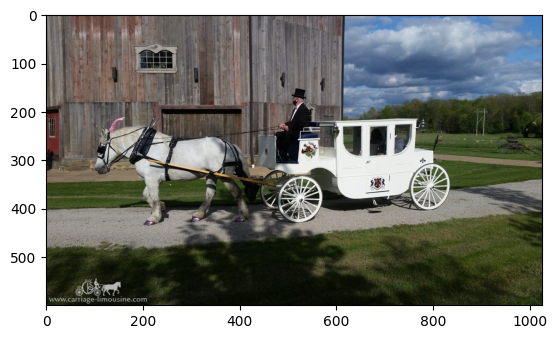

In [77]:
import imageio.v2 as imageio

question1 = 'where this picture taken?'
img_path1 = '/Users/rajnishjha/Desktop/horse_drawn_royal_coach_101.jpeg'

plt.imshow(imageio.imread(img_path1))

q_feat = q_embedding(question1, bow_q, bow_123).reshape(1,-1)
i_feat = extract_features(img_path1, vgg19_model_extractfeatures)

feat = np.hstack((q_feat, i_feat))

y_pred = np.argmax(model.predict(feat),axis=1)

print(question1)

print('*'*50)
print(str(labelencoder.inverse_transform(y_pred)))

1/1 [==============================] - 0s 21ms/step
how many person in the picture?
**************************************************
['kia']


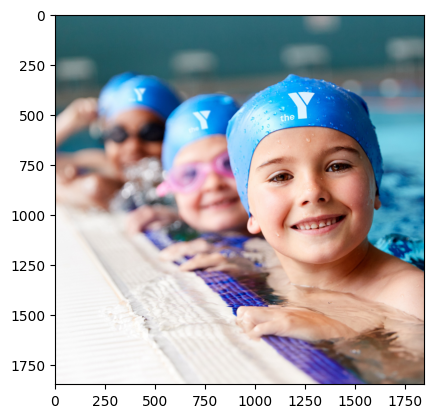

In [86]:
question2 = 'how many person in the picture?'
img_path2 = '/Users/rajnishjha/Desktop/page-004.jpg'

plt.imshow(imageio.imread(img_path2))

q_feat = q_embedding(question2, bow_q, bow_123).reshape(1,-1)
i_feat = extract_features(img_path2, vgg19_model_extractfeatures)

feat = np.hstack((q_feat, i_feat))

y_pred = np.argmax(model.predict(feat),axis=1)


print(question2)
print('*'*50)
print(str(labelencoder.inverse_transform(y_pred)))